## Boundaries of the Mandelbrot set with Jungreis version

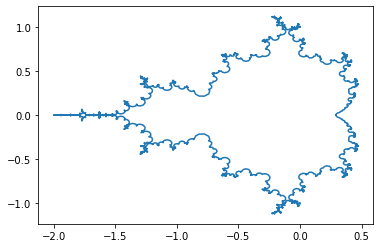

In [1]:
import numpy as np
import matplotlib.pyplot as plt

nstore = 3000  #cachesize should be more or less as high as the coefficients
betaF_cachedata = np.zeros( (nstore,nstore))
betaF_cachemask = np.zeros( (nstore,nstore),dtype=bool)
def betaF(n,m):
    """
    This function was translated to python from
    http://fraktal.republika.pl/mset_jungreis.html
    It computes the Laurent series coefficients of the jungreis function
    that can then be used to map the unit circle to the Mandelbrot
    set boundary. The mapping of the unit circle can also
    be seen as a Fourier transform. 
    I added a very simple global caching array to speed it up
    """
    global betaF_cachedata,betaF_cachemask

    nnn=2**(n+1)-1
    if betaF_cachemask[n,m]:
        return betaF_cachedata[n,m]
    elif m==0:
        return 1.0
    elif ((n>0) and (m < nnn)):
        return 0.0
    else: 
        value = 0.
        for k in range(nnn,m-nnn+1):
            value += betaF(n,k)*betaF(n,m-k)
        value = (betaF(n+1,m) - value - betaF(0,m-nnn))/2.0 
        betaF_cachedata[n,m] = value
        betaF_cachemask[n,m] = True
        return value

def main():
    #compute coefficients (reduce ncoeffs to make it faster)
    ncoeffs= 2400
    coeffs = np.zeros( (ncoeffs) )
    for m in range(ncoeffs):
#         if m%100==0: 
#             print(m,ncoeffs)
        coeffs[m] = betaF(0,m+1)

    #map the unit circle  (cos(nt),sin(nt)) to the boundary
    npoints = 10000
    points = np.linspace(0,2*np.pi,npoints)
    xs     = np.zeros(npoints)
    ys     = np.zeros(npoints)
    xs = np.cos(points)
    ys = -np.sin(points)
    for ic,coeff in enumerate(coeffs):
        xs += coeff*np.cos(ic*points)
        ys += coeff*np.sin(ic*points)
    
    #plot the function
    plt.figure()
    plt.plot(xs,ys)
    plt.show()
    
if __name__ == "__main__":
    main()

## Hyperbolic boundaries of the Mandelbrot set with Distance estimation method

The escape radius is a parameter used in iterating a point under the Mandelbrot Set and Julia Set functions. It is the radius of a circle on the Complex Plane used as a boundary to determine when iteration can stop. The circle is centered at the origin, and has a radius of at least 2.0. As soon as the iteration yields a value that falls outside the circle, iteration can stop and it has been determined that the point that was iterated is not a member of the Mandelbrot Set.

"you need to change "If mag > 2" to increase the escape radius. Attached is a comparison, showing that the "straps" reduce when the radius is increased, no harm going huge like R = 1e6 or so because once it escapes 2 it grows very fast. The bigger the radius, the more accurate the distance estimate.

For more information, see - https://en.wikibooks.org/wiki/Fractals/Iterations_in_the_complex_plane/demm

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def linear_map(a, b, x, image_dim):
    return int(np.interp(x, [a,b], [0, image_dim-1]))
    

#store set of numbers and plot the set boundary
mandel_list = []
image_dim = 256
plot_Mat = 255 * np.ones((image_dim, image_dim))


#all possible points in the mandelbrot set(reduce ncoeffs to make it faster)
cr_min = -2
cr_max = 0.75

ci_min = -1.5
ci_max = 1.5


cr = np.linspace(cr_min, cr_max, image_dim)
ci = np.linspace(ci_min, ci_max, image_dim)
c_list = np.zeros((image_dim, image_dim), dtype = complex)
for i in range(image_dim):
    for j in range(image_dim):
        c_list[i,j] = cr[i] + 1j*ci[j]
        
escape_radius = 1e6
maxiter = 500
mindist = 1e-6


#iterate over c's
[nrow, ncol] = np.shape(c_list)

for i in range(nrow):
    for j in range(ncol):
        
        c = c_list[i,j]
    
        escape_flag = False
        niter = 1

        #initial points
        z = c
        dz = 1.0 + 0*1j
        
        while not escape_flag and niter < maxiter:

            dz = 2 * z * dz + 1
            z = np.power(z,2) + c
            niter += 1
            escape_flag = True if (np.abs(z) > escape_radius) else False

        distance =  2 * np.abs(z) * (np.log(np.abs(z))/np.abs(dz))
        
        posx = linear_map(cr_min, cr_max, np.real(c), image_dim)
        posy = linear_map(ci_min, ci_max, np.imag(c), image_dim)
        plot_Mat[posx, posy] = np.tanh(distance)*255

        if np.abs(distance) < mindist:
#             print(c, 'is on boundary of mandelbrot set')
            mandel_list.append(c)
        


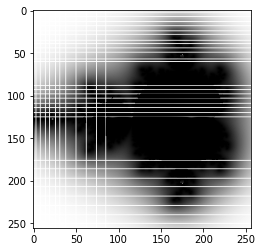

Text(0.5, 1.0, 'Mandelbrot set boundary')

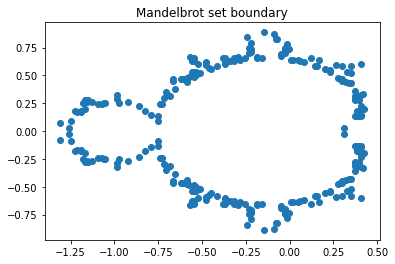

In [117]:
#for plotting

plt.figure()
plt.imshow(plot_Mat.T, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()

x_plot = np.real(mandel_list)
y_plot = np.imag(mandel_list)
plt.figure()
plt.scatter(x_plot, y_plot)
plt.title('Mandelbrot set boundary')


In [175]:
# save mandelbrot set points in a file 

with open("bin/data/mandelbrot_boundary.txt", "w") as f:
    for c in mandel_list:
        f.write(str(np.real(c)) +"\t" + str(np.imag(c)) + "\n")
        
        

## Julia sets corresponding to the points on the Mandelbrot set boundary

In [2]:
# read from saved mandelbrot set 
import re
import numpy as np
import matplotlib.pyplot as plt


with open("bin/data/mandelbrot_boundary.txt") as f:
    comp_num = f.read().splitlines()
         
mandel_list_copy = []
for elem in comp_num:
    string = re.split(r'\t', elem)
    mandel_list_copy.append(float(string[0]) + 1j*float(string[1]))


#initialize and create inputs

def linear_map(a, b, x, image_dim):
    return (np.interp(x, [a,b], [0, image_dim-1])).astype(int)

image_dim = 1024
zr_min = -1.5
zr_max = 1.5
zi_min = -1
zi_max = 1

zr = np.linspace(zr_min, zr_max, image_dim)
zi = np.linspace(zi_min, zi_max, image_dim)
z_list = np.zeros((image_dim, image_dim), dtype = complex)
for i in range(image_dim):
    for j in range(image_dim):
        z_list[i,j] = zr[i] + 1j*zi[j]
z_all = z_list.flatten()

posx = linear_map(zr_min, zr_max, np.real(z_all), image_dim)
posy = linear_map(zi_min, zi_max, np.imag(z_all), image_dim)
    

In [ ]:
# for pretty rainbow plotting
from colorsys import hls_to_rgb

def rainbow_color_stops(n, end=2/3):
    return [ hls_to_rgb(end * i/(n-1), 0.5, 1) for i in range(n) ]


# check if inputs are in the Julia set
maxiter = 200
colors = rainbow_color_stops(maxiter+1)

my_dpi = 200
plt.figure(figsize=(image_dim/my_dpi, image_dim/my_dpi), dpi=my_dpi)
numcheck = 0

for c in mandel_list_copy[2:142]:
  
    plot_Mat = np.tile(colors[-1], (image_dim, image_dim, 1))
    R = (1 + np.sqrt(1 + 4*np.abs(c)))/2
    numpos = 0
    
    for comp_num in z_all:
        
        niter = 0
        escape_flag = False
        z = comp_num
        
        while niter < maxiter and not escape_flag:
            z = np.power(z,2) + c
            niter += 1
            if np.abs(z) > R:
                escape_flag = True
                
        if not escape_flag:
            plot_Mat[posx[numpos], posy[numpos]] = [0,0,0]
        else:
            plot_Mat[posx[numpos], posy[numpos]] = colors[-niter]
        
        numpos += 1
    
      
        
    numcheck += 1
    plt.imshow(plot_Mat)
    plt.savefig('bin/data/Figures/' + str(numcheck) + '.png', dpi = my_dpi)
    
    print('Finished computing ' + str(numcheck) + ' out of ' + str(len(mandel_list_copy)) + ' sets.')
    

In [ ]:
#save as gif    
import imageio

with imageio.get_writer('bin/data/julia-set.gif', mode='I', fps=2) as writer:
    for i in range(1,len(mandekl_list_copy)):
        filename = 'Figures/' + str(i) + '.png'
        image = imageio.imread(filename)
        writer.append_data(image)
        
print("Done writing gif")


In [ ]:
# save the structural similarity index between each pair of images
# for 266 images, this will write 266*266 values

import skimage as ski
nimages = len(mandel_list_copy)-2

with open("bin/data/julia_image_similarities.txt", "a+") as f:
    
    for i in range(47, nimages+1):
        
        img1 = ski.io.imread('bin/data/Figures/' + str(i) + '.png')
        img1 = img1[:,:,0]
        for j in range(1,nimages+1):
            img2 = ski.io.imread('bin/data/Figures/' + str(j) + '.png')
            img2 = img2[:,:,0]
            ssim = ski.metrics.structural_similarity(img1, img2, win_size=101)
            f.write(str(ssim) + '\t')
            
        f.write('\n')
        print('Processed '+ str(i) + ' out of ' + str(nimages) + ' images' )
        
print ("finished calculating structural similarity")

